In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install cellpose

  Using cached cellpose-3.0.10-py3-none-any.whl (204 kB)
  Using cached fastremap-1.14.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.0 MB)
  Using cached imagecodecs-2024.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.5 MB)
  Using cached roifile-2024.5.24-py3-none-any.whl (16 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.w

# **Original Image and Masks**


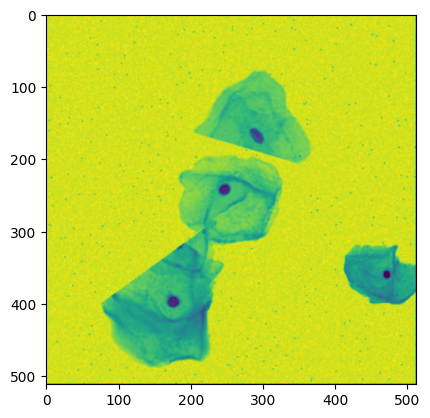

In [5]:
import matplotlib.pyplot as plt
plt.imshow(mat_contents['ISBI_Train'][10][0])

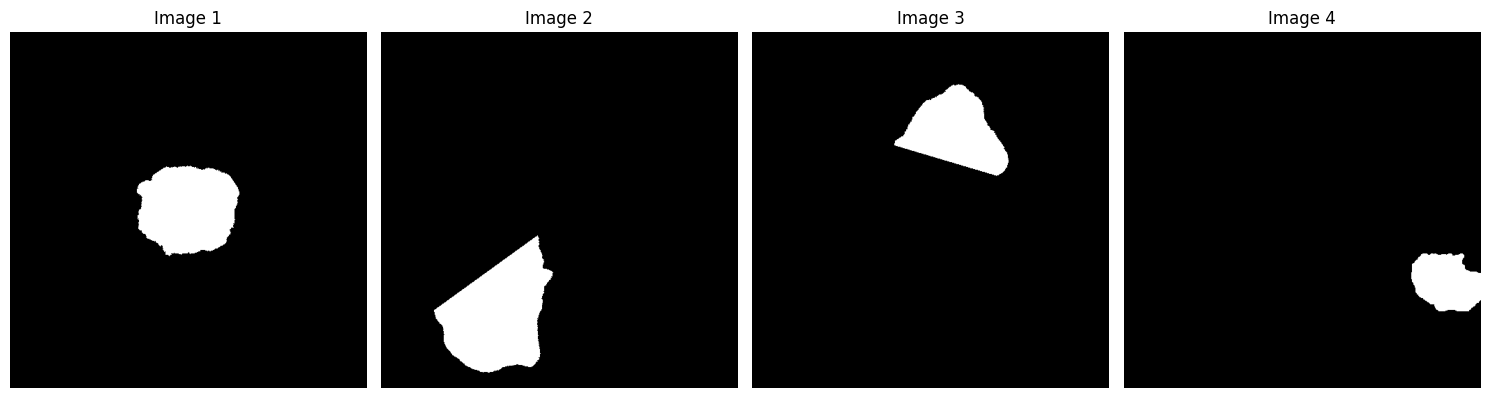

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axs[i].imshow(mat_contentsGT['train_Cytoplasm'][10][0][i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

# **Combining individual masks**

In [4]:
import scipy.io
import numpy as np
mat_file_pathGT = '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_train_GT.mat'
mat_file_path = '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_train.mat'
mat_contentsGT = scipy.io.loadmat(mat_file_pathGT)
mat_contents = scipy.io.loadmat(mat_file_path)
def load_data_train(image_path, mask_path):
    # Load the .mat files
    image_data = scipy.io.loadmat(image_path)
    mask_data = scipy.io.loadmat(mask_path)

    images = image_data['ISBI_Train']
    masks = mask_data['train_Cytoplasm']

    combined_masks = []
    for i in range(len(images)):
        combined_mask = np.zeros_like(images[i][0], dtype=np.uint8)

    # Iterate through each image and its corresponding masks
    for i in range(len(images)):
        # Start with an empty mask of zeros (background)
        combined_mask = np.zeros_like(images[i][0], dtype=np.uint8)

        # Loop through each cell's mask and assign unique labels
        for label, cell_mask in enumerate(masks[i][0], start=1):
            combined_mask[cell_mask[0] > 0] = label

        combined_masks.append(combined_mask)

    return np.array(images), np.array(combined_masks)

def load_data_test(image_path, mask_path):
    # Load the .mat files
    image_data = scipy.io.loadmat(image_path)
    mask_data = scipy.io.loadmat(mask_path)

    images = image_data['ISBI_Test90']
    masks = mask_data['test_Cytoplasm']

    combined_masks = []

    # Iterate through each image and its corresponding masks
    for i in range(len(images)):
        # Start with an empty mask of zeros (background)
        combined_mask = np.zeros_like(images[i][0], dtype=np.uint8)

        # Loop through each cell's mask and assign unique labels
        for label, cell_mask in enumerate(masks[i][0], start=1):
            combined_mask[cell_mask[0] > 0] = label

        combined_masks.append(combined_mask)

    return np.array(images), np.array(combined_masks)
# Assuming 'path_to_images.mat' and 'path_to_masks.mat' are the paths to your .mat files
img, combined_masks = load_data_train('/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_train.mat', '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_train_GT.mat')
test_img , test_combined_masks = load_data_test('/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_test90.mat', '/content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_test90_GT.mat')

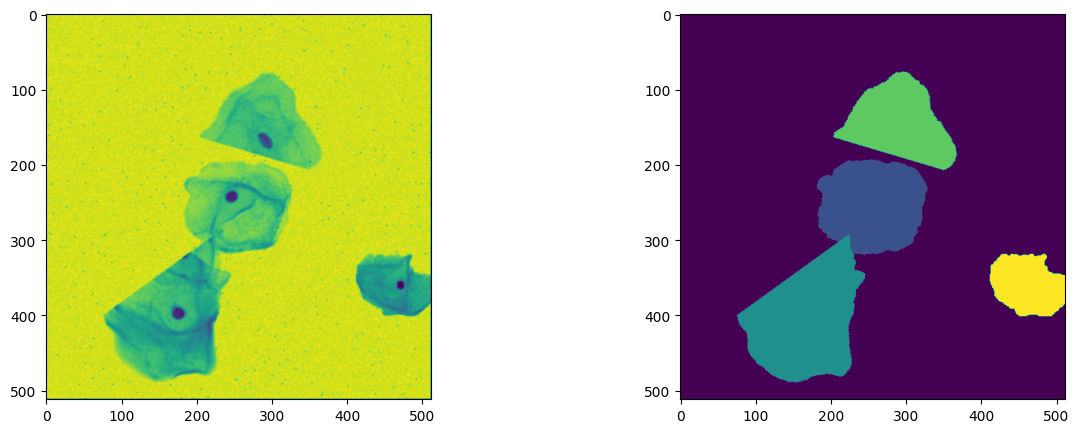

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(img[10][0])
axs[1].imshow(combined_masks[10])

# **Finetuning Cellpose model**

In [ ]:
train_data = scipy.io.loadmat('//content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_train.mat')
test_data = scipy.io.loadmat('//content/drive/MyDrive/Cell-Segmentation/ISBI_dataset/isbi_test90.mat')
images = []

for i in range(45):
        images.append(train_data['ISBI_Train'][i][0])
img = images
images = []
for i in range(90):
        images.append(test_data['ISBI_Test90'][i][0])
test_img = images

In [ ]:
from cellpose import io, models, train
io.logger_setup()
# e.g. retrain a Cellpose model
model = models.CellposeModel(model_type="cyto3")

model_path = train.train_seg(model.net, train_data=img, train_labels=combined_masks,
                            channels=[0,0], normalize=True,
                            test_data=test_img, test_labels=test_combined_masks,
                            weight_decay=1e-4, SGD=True, learning_rate=0.1,
                            n_epochs=100, model_name="my_new_model")

creating new log file


100%|██████████| 25.3M/25.3M [00:03<00:00, 8.81MB/s]
100%|██████████| 90/90 [00:00<00:00, 859.19it/s]


In [ ]:
import pickle
# Save the trained model to Google Drive
model_save_path = '/content/drive/MyDrive/Cell-Segmentation/cytoplasm_segmentation_model.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/my_trained_model.pkl
